# 1 Introduction

This project will make you construct a portfolio that combines international stock market indices and currency exposures to analyze the benefits to international diversification, as well as the benefits to timing your allocation to international stock markets and currencies based on a small set of predictive signals including: carry, dollar, reversal, and momentum.

In [97]:
# Installing the required packages
!pip install -r requirements.txt

DEPRECATION: Loading egg at /Users/matthiaswyss/anaconda3/lib/python3.11/site-packages/ibapi-10.30.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


# 2 The Data

Download monthly stock returns from WRDS Monthly World Indices from 2002-01 to 2024-12 for the following stock market indices of the following country: Australia, France, Germany, Japan, Switzerland, the United Kingdom, and the CRSP’s value-weighted return index for the US. Download also the 1-month T-Bill.

Further, download the exchange rate vis-a-vis the USD for the relevant currencies: AUD, EUR, JPY, CHF, GBP. Also, download the 3-month interbank rate corresponding to each country. These data can be found on FRED website.

In [98]:
# Import necessary libraries
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy.linalg import inv
from scipy import stats
import statsmodels.api as sm

In [99]:
# Reads monthly exchange rates from CHF to USD and writes the inverted rates (USD to CHF) to a new file.

input_file = 'data/monthly_exchange_rate/monthly_CHF_to_one_USD.csv'
output_file = 'data/monthly_exchange_rate/monthly_USD_to_one_CHF.csv'

with open(input_file, mode='r', newline='') as infile, open(output_file, mode='w', newline='') as outfile:
    reader = csv.DictReader(infile)
    
    fieldnames = ['date', 'EXUSSZ']
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for row in reader:
        try:
            original_rate = float(row['EXSZUS'])
            inverted_rate = 1 / original_rate
            writer.writerow({
                'date': row['date'],
                'EXUSSZ': round(inverted_rate, 4)
            })
        except (ValueError, ZeroDivisionError):
            print(f"Skipped invalid row: {row}")

In [100]:
# Reads monthly exchange rates from JPY to USD and writes the inverted rates (USD to JPY) to a new file.

input_file = 'data/monthly_exchange_rate/monthly_JPY_to_one_USD.csv'
output_file = 'data/monthly_exchange_rate/monthly_USD_to_one_JPY.csv'

with open(input_file, mode='r', newline='') as infile, open(output_file, mode='w', newline='') as outfile:
    reader = csv.DictReader(infile)
    
    fieldnames = ['date', 'EXUSJP']
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for row in reader:
        try:
            original_rate = float(row['EXJPUS'])
            inverted_rate = 1 / original_rate
            writer.writerow({
                'date': row['date'],
                'EXUSJP': round(inverted_rate, 4)
            })
        except (ValueError, ZeroDivisionError):
            print(f"Skipped invalid row: {row}")

In [101]:
# loads monthly USD exchange rate data for five currencies, 
# renames the columns for clarity, merges them into a single DataFrame, 
# and saves the result as a CSV file.


# Load exchange rate data for each currency (USD to one unit of foreign currency)
df_chf_rate = pd.read_csv('data/monthly_exchange_rate/monthly_USD_to_one_CHF.csv')
df_jpy_rate = pd.read_csv('data/monthly_exchange_rate/monthly_USD_to_one_JPY.csv')
df_aud_rate = pd.read_csv('data/monthly_exchange_rate/monthly_USD_to_one_AUD.csv')
df_eur_rate = pd.read_csv('data/monthly_exchange_rate/monthly_USD_to_one_EUR.csv')
df_gbp_rate = pd.read_csv('data/monthly_exchange_rate/monthly_USD_to_one_GBP.csv')

# Rename the columns for clarity, representing the exchange rate from USD to each currency
df_chf_rate.rename(columns={'EXUSSZ': 'USD_per_CHF'}, inplace=True)
df_jpy_rate.rename(columns={'EXUSJP': 'USD_per_JPY'}, inplace=True)
df_aud_rate.rename(columns={'EXUSAL': 'USD_per_AUD'}, inplace=True)
df_eur_rate.rename(columns={'EXUSEU': 'USD_per_EUR'}, inplace=True)
df_gbp_rate.rename(columns={'EXUSUK': 'USD_per_GBP'}, inplace=True)

# Merge all the exchange rate dataframes on the 'date' column, using outer joins to retain all dates
df_merged_rates = df_chf_rate[['date', 'USD_per_CHF']].merge(df_jpy_rate[['date', 'USD_per_JPY']], on='date', how='outer') \
    .merge(df_aud_rate[['date', 'USD_per_AUD']], on='date', how='outer') \
    .merge(df_eur_rate[['date', 'USD_per_EUR']], on='date', how='outer') \
    .merge(df_gbp_rate[['date', 'USD_per_GBP']], on='date', how='outer')

# Convert the 'date' column to datetime format
df_merged_rates['date'] = pd.to_datetime(df_merged_rates['date']).dt.to_period('M').dt.to_timestamp()

# Setting the date column as the index
df_merged_rates.set_index('date', inplace=True)

# Remove the first row to match 3-month interbank data
df_merged_rates = df_merged_rates.iloc[1:]

# Create the directory if it doesn't exist
os.makedirs('data/preprocess', exist_ok=True)

# Save the merged exchange rate data to a new CSV file
df_merged_rates.to_csv('data/preprocess/merged_exchange_rates.csv')

# Display the first few rows of the final merged DataFrame
df_merged_rates.head()

,USD_per_CHF,USD_per_JPY,USD_per_AUD,USD_per_EUR,USD_per_GBP
date,,,,,
2002-05-01,0.6294,0.0079,0.5498,0.9170,1.4598
2002-06-01,0.6494,0.0081,0.5682,0.9561,1.4837
2002-07-01,0.6794,0.0085,0.5538,0.9935,1.5565
2002-08-01,0.6679,0.0084,0.5413,0.9781,1.5368
2002-09-01,0.6697,0.0083,0.5465,0.9806,1.5563


In [102]:
# Import the T-Bill data
df_tbills = pd.read_csv('data/monthly_returns/tbills.csv')

# Convert the 'date' column to datetime and shift to the beginning of the next month
df_tbills['date'] = (pd.to_datetime(df_tbills['date']) + pd.offsets.MonthBegin(1))

# Set the date column as the index
df_tbills.set_index('date', inplace=True)

# Remove the last row to match monthly returns data
df_tbills = df_tbills.iloc[:-1]

# Save the processed T-Bill data to a new CSV file
df_tbills.to_csv('data/preprocess/tbills.csv')

# Display the first few rows of the final DataFrame
df_tbills.head()

,rf
date,
2002-05-01,0.0015
2002-06-01,0.0014
2002-07-01,0.0013
2002-08-01,0.0015
2002-09-01,0.0014


In [103]:
# Loads monthly returns data for various countries, merges the data with CRSP (US returns) and T-bills data, 
# and standardizes the columns to include the returns for each country in the correct format, 
# before saving the final merged DataFrame.


# Folder path containing the return data files
path = "data/monthly_returns/"

# List of country-specific return files (excluding 'csrp_return.csv' and 'tbills.csv')
country_files = [
    "australia_return.csv", "france_return.csv", "germany_return.csv",
    "japan_return.csv", "swiss_return.csv", "uk_return.csv"
]

# Initialize an empty DataFrame for storing merged monthly returns data
df_all_country_returns = None

# Load and process country-specific return data files
for file in country_files:
    # Load each country's return file
    df_country_return = pd.read_csv(path + file)

    # Extract country and currency from the first row
    country = df_country_return['country'].iloc[0].lower()   # e.g., "AUSTRALIA" -> "australia"
    currency = df_country_return['currency'].iloc[0].lower() # e.g., "AUD" -> "aud"

    # Manually fix uk
    if country == "united kingdom":
        country = "uk"

    # Convert the 'date' column to datetime and shift to the beginning of the next month
    df_country_return['date'] = pd.to_datetime(df_country_return['date']) + pd.offsets.MonthBegin(1)

    # Keep only relevant columns
    df_country_return = df_country_return[['date', 'mportret', 'mportretx']]

    # Rename columns to include the country and currency
    df_country_return = df_country_return.rename(columns={
        'mportret': f'{country}_ret_with_div_{currency}',
        'mportretx': f'{country}_ret_without_div_{currency}'
    })

    # Merge the current country's data into the final DataFrame
    if df_all_country_returns is None:
        df_all_country_returns = df_country_return
    else:
        df_all_country_returns = pd.merge(df_all_country_returns, df_country_return, on='date', how='outer')

# Load and process the CRSP (US returns) data
df_crsp_returns = pd.read_csv(path + "csrp_return.csv")
df_crsp_returns['date'] = pd.to_datetime(df_crsp_returns['date']) + pd.offsets.MonthBegin(1)
df_crsp_returns = df_crsp_returns[['date', 'vwretd', 'vwretx']]
df_crsp_returns = df_crsp_returns.rename(columns={
    'vwretd': 'us_ret_with_div_usd',
    'vwretx': 'us_ret_without_div_usd'
})
# Merge CRSP returns with the existing DataFrame
df_all_country_returns = pd.merge(df_all_country_returns, df_crsp_returns, on='date', how='outer')

# Sort the final DataFrame by 'date' and reset the index
df_all_country_returns = df_all_country_returns.sort_values('date')

# Setting the date column as the index
df_all_country_returns.set_index('date', inplace=True)

# Separate columns that contain returns with and without dividends
df_returns_with_div = df_all_country_returns.filter(like='_ret_with_div_')
df_returns_without_div = df_all_country_returns.filter(like='_ret_without_div_')

# Remove the last row to match monthly returns data
df_returns_with_div = df_returns_with_div.iloc[:-1]
df_returns_without_div = df_returns_without_div.iloc[:-1]

# Save both DataFrames to separate CSV files
df_returns_with_div.to_csv("data/preprocess/merged_returns_with_dividends.csv")
df_returns_without_div.to_csv("data/preprocess/merged_returns_without_dividends.csv")

# Display the first few rows of the with dividends DataFrame
df_returns_with_div.head()

,australia_ret_with_div_aud,france_ret_with_div_eur,germany_ret_with_div_eur,japan_ret_with_div_jpy,switzerland_ret_with_div_chf,uk_ret_with_div_gbp,us_ret_with_div_usd
date,,,,,,,
2002-05-01,-0.014302,-0.043988,-0.045031,0.020586,-0.004109,-0.013362,-0.049600
2002-06-01,-0.000204,-0.028016,-0.025703,0.035987,0.002963,-0.011482,-0.010510
2002-07-01,-0.026756,-0.080806,-0.068682,-0.083764,-0.081687,-0.082525,-0.070259
2002-08-01,-0.037816,-0.104069,-0.108894,-0.057720,-0.132371,-0.089530,-0.081125
2002-09-01,0.016208,-0.004621,-0.002896,-0.024411,0.005083,0.002874,0.007949


In [104]:
# This code processes the interbank rate data for multiple countries, 
# merges them into a single DataFrame with the date as the index, 
# and renames the columns to explicitly indicate the three-month interbank rates for each country 
# (AUD, CHF, EUR, GBP, JPY, US).


# Define the path to the folder containing the interbank rate files
path = "data/three_month_interbank_rate/"

# List of country files (with the format country_three_month_interbank_rate)
country_files = [
    "three_month_interbank_rate_AUD.csv", 
    "three_month_interbank_rate_CHF.csv", 
    "three_month_interbank_rate_EUR.csv",
    "three_month_interbank_rate_GBP.csv", 
    "three_month_interbank_rate_JPY.csv", 
    "three_month_interbank_rate_USD.csv"
]

# Initialize the final merged DataFrame with None
df_three_month_rates_merged = None

# Loop through each file and process the data
for file in country_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(path + file)

    # Extract country name from the filename (assume the pattern is 'three_month_interbank_rate_<country>.csv')
    country = file.split('_')[4].split('.')[0].lower()  # e.g. 'AUD' for Australia

    # Rename the columns for better understanding with explicit names
    df = df.rename(columns={
        df.columns[1]: f'three_month_interbank_rate_{country.upper()}'  # Explicit column names
    })

    # Convert 'observation_date' to datetime and standardize the format to YYYY-MM
    df['observation_date'] = pd.to_datetime(df['observation_date']).dt.to_period('M').dt.to_timestamp()

    # Keep only the 'observation_date' and the relevant rate column
    df = df[['observation_date', f'three_month_interbank_rate_{country.upper()}']]

    # Merge with the final DataFrame
    if df_three_month_rates_merged is None:
        df_three_month_rates_merged = df
    else:
        df_three_month_rates_merged = pd.merge(df_three_month_rates_merged, df, on='observation_date', how='outer')

# Sort the final merged DataFrame by 'observation_date'
df_three_month_rates_merged = df_three_month_rates_merged.sort_values('observation_date').reset_index(drop=True)

# Rename the 'observation_date' column to 'date' for consistency
df_three_month_rates_merged.rename(columns={'observation_date': 'date'}, inplace=True)

# Iterate through all currency columns to check for missing values
currency_columns = [col for col in df_three_month_rates_merged.columns if 'three_month_interbank_rate_' in col]

# Check for missing values for each currency and print the dates associated
for col in currency_columns:
    missing_data = df_three_month_rates_merged[df_three_month_rates_merged[col].isna()]
    
    if not missing_data.empty:
        print(f"Missing data for {col.split('_')[-1].upper()}:")
        print(missing_data[['date', col]])
        print("\n")

Missing data for USD:
          date  three_month_interbank_rate_USD
216 2020-04-01                             NaN




In [105]:
# Fills the missing value in US three-month interbank rate series by averaging March and May 2020 
# for the missing US value in April 2020, then saves the cleaned dataset to a CSV file.


# Getting the values for March and May 2020
us_col = 'three_month_interbank_rate_USD'
us_mar_val = df_three_month_rates_merged.loc[
    df_three_month_rates_merged['date'] == pd.Timestamp('2020-03-01'), us_col
].values[0]
us_may_val = df_three_month_rates_merged.loc[
    df_three_month_rates_merged['date'] == pd.Timestamp('2020-05-01'), us_col
].values[0]

# Compute the mean if both values are not NaN
us_avg = np.nanmean([us_mar_val, us_may_val])

# Set April 2020 value
df_three_month_rates_merged.loc[
    df_three_month_rates_merged['date'] == pd.Timestamp('2020-04-01'), us_col
] = us_avg

# Convert all numeric columns (interest rates) from percent to decimal
numeric_cols = df_three_month_rates_merged.select_dtypes(include=[np.number]).columns
df_three_month_rates_merged[numeric_cols] = df_three_month_rates_merged[numeric_cols] / 100

# Set date as index
df_three_month_rates_merged.set_index('date', inplace=True)

# Remove the first row to match the previous data
df_three_month_rates_merged = df_three_month_rates_merged.iloc[1:]

# Save the merged DataFrame to a CSV file
df_three_month_rates_merged.to_csv(f"data/preprocess/merged_three_month_interbank_rates.csv")

# Display the final DataFrame
df_three_month_rates_merged.head()

,three_month_interbank_rate_AUD,three_month_interbank_rate_CHF,three_month_interbank_rate_EUR,three_month_interbank_rate_GBP,three_month_interbank_rate_JPY,three_month_interbank_rate_USD
date,,,,,,
2002-05-01,0.0484,0.011635,0.034671,0.041537,0.0008,0.0182
2002-06-01,0.0507,0.011496,0.034640,0.041776,0.0009,0.0181
2002-07-01,0.0498,0.010031,0.034100,0.040605,0.0009,0.0179
2002-08-01,0.0496,0.006683,0.033519,0.039865,0.0007,0.0173
2002-09-01,0.0492,0.006130,0.033101,0.039887,0.0008,0.0176


# 3 The international diversification strategy (DIV)

(a) Compute the returns to each of the stock market indexes in USD by converting the local currency returns into USD using the appropriate exchange rate.


In [106]:
# Q3A

# Load the country returns data (only with dividends)
df_country_returns = pd.read_csv("data/preprocess/merged_returns_with_dividends.csv", parse_dates=['date'], index_col='date')

# Load the exchange rate data
df_exchange_rates = pd.read_csv("data/preprocess/merged_exchange_rates.csv", parse_dates=['date'], index_col='date')

# Merge the exchange rate data with the country returns data on 'date'
df_country_returns = pd.merge(df_country_returns, df_exchange_rates, on='date', how='left')

# Mapping from currency codes to exchange rate columns (USD per unit of foreign currency)
currency_to_fx_col = {
    'aud': 'USD_per_AUD',
    'eur': 'USD_per_EUR',
    'chf': 'USD_per_CHF',
    'jpy': 'USD_per_JPY',
    'gbp': 'USD_per_GBP'
}

# Compute exchange rate returns (Rex) in USD
for curr, fx_col in currency_to_fx_col.items():
    df_country_returns[f'Rex_{curr}'] = df_country_returns[fx_col].pct_change()

# Convert all local returns with dividends to USD returns using logarithmic approximation
converted_cols = {}

for col in df_country_returns.columns:
    if '_ret_with_div_' in col:
        for curr, fx_col in currency_to_fx_col.items():
            if col.endswith(f'_{curr}'):
                rex_col = f'Rex_{curr}'
                new_col = col.replace(f'_{curr}', '_usd')
                df_country_returns[new_col] = (df_country_returns[col] + 1) * (df_country_returns[rex_col] + 1) - 1
                converted_cols[col] = new_col
                break

# Keep only the date and the converted USD return columns (plus US and T-bill returns already in USD)
usd_columns = [col for col in df_country_returns.columns if col.endswith('_usd')]

# Create final DataFrame and drop NaN values
df_monthly_return_usd = df_country_returns[usd_columns].dropna(how='any')

# Create the directory if it doesn't exist
os.makedirs('data/q3', exist_ok=True)

# Save final USD return DataFrame
df_monthly_return_usd.to_csv("data/q3/monthly_returns_in_usd.csv")

# Show a preview
df_monthly_return_usd.head()

,us_ret_with_div_usd,australia_ret_with_div_usd,france_ret_with_div_usd,germany_ret_with_div_usd,japan_ret_with_div_usd,switzerland_ret_with_div_usd,uk_ret_with_div_usd
date,,,,,,,
2002-06-01,-0.010510,0.033256,0.013428,0.015840,0.062215,0.034833,0.004702
2002-07-01,-0.070259,-0.051421,-0.044850,-0.032251,-0.038518,-0.039264,-0.037508
2002-08-01,-0.081125,-0.059533,-0.117957,-0.122706,-0.068806,-0.147058,-0.101053
2002-09-01,0.007949,0.025970,-0.002077,-0.000348,-0.036025,0.007791,0.015599
2002-10-01,-0.099923,-0.033042,-0.148085,-0.204420,-0.044786,-0.089463,-0.113735


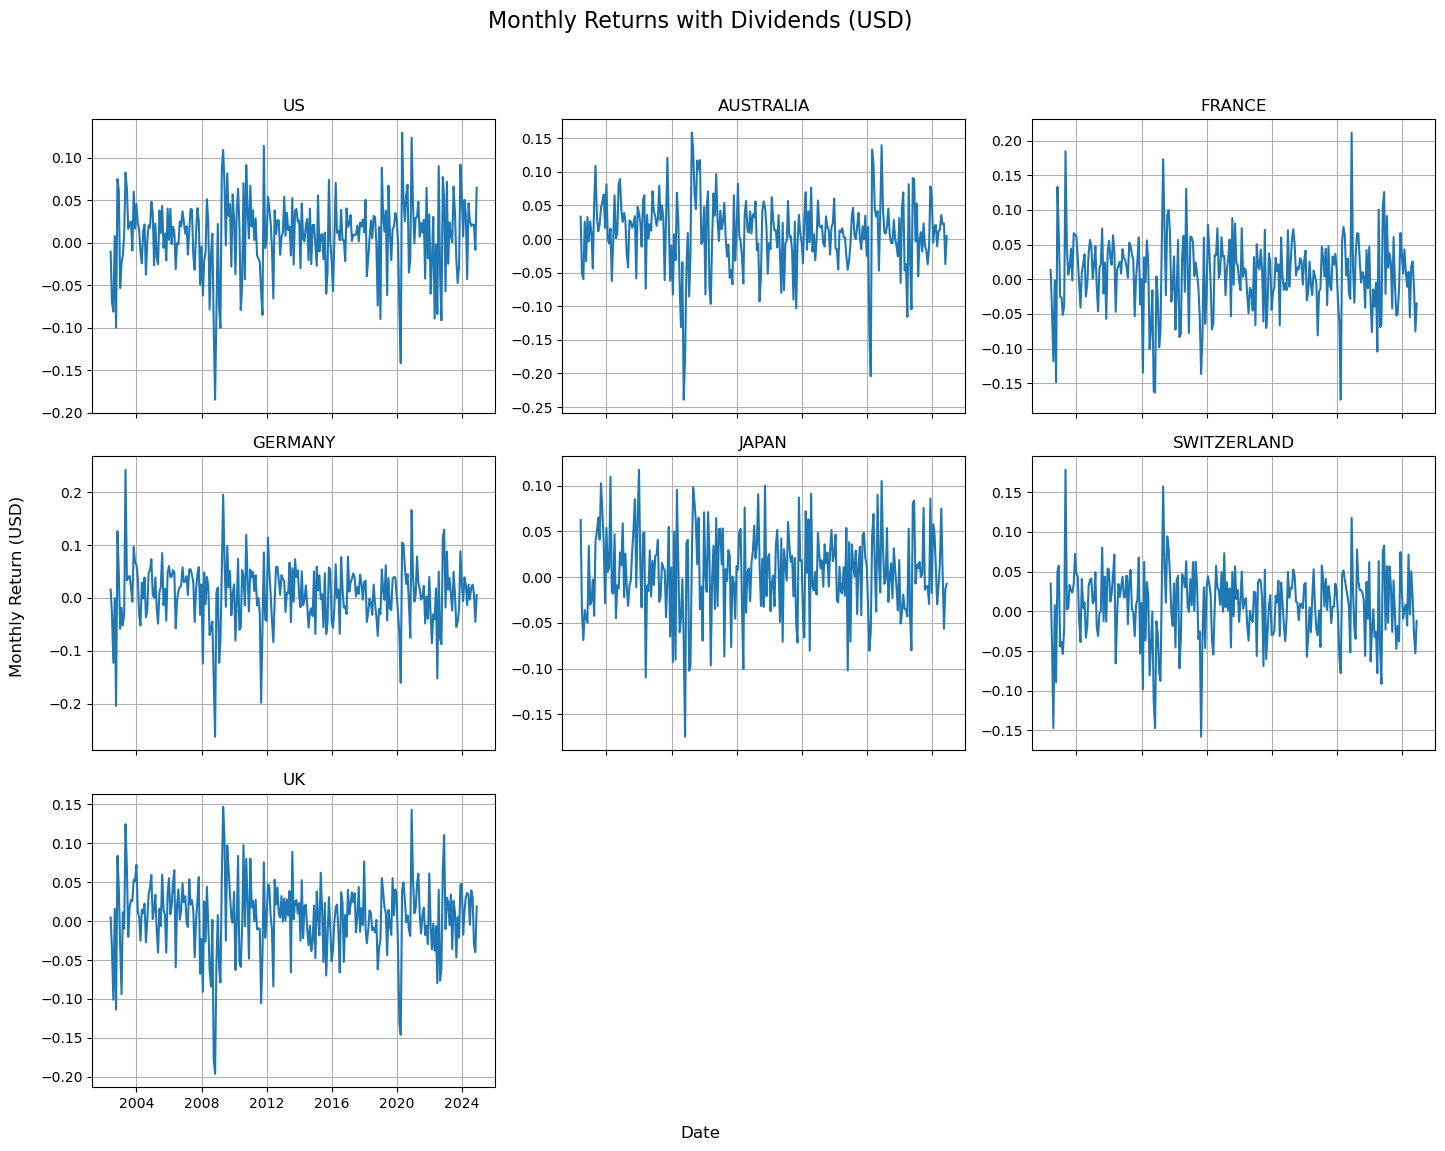

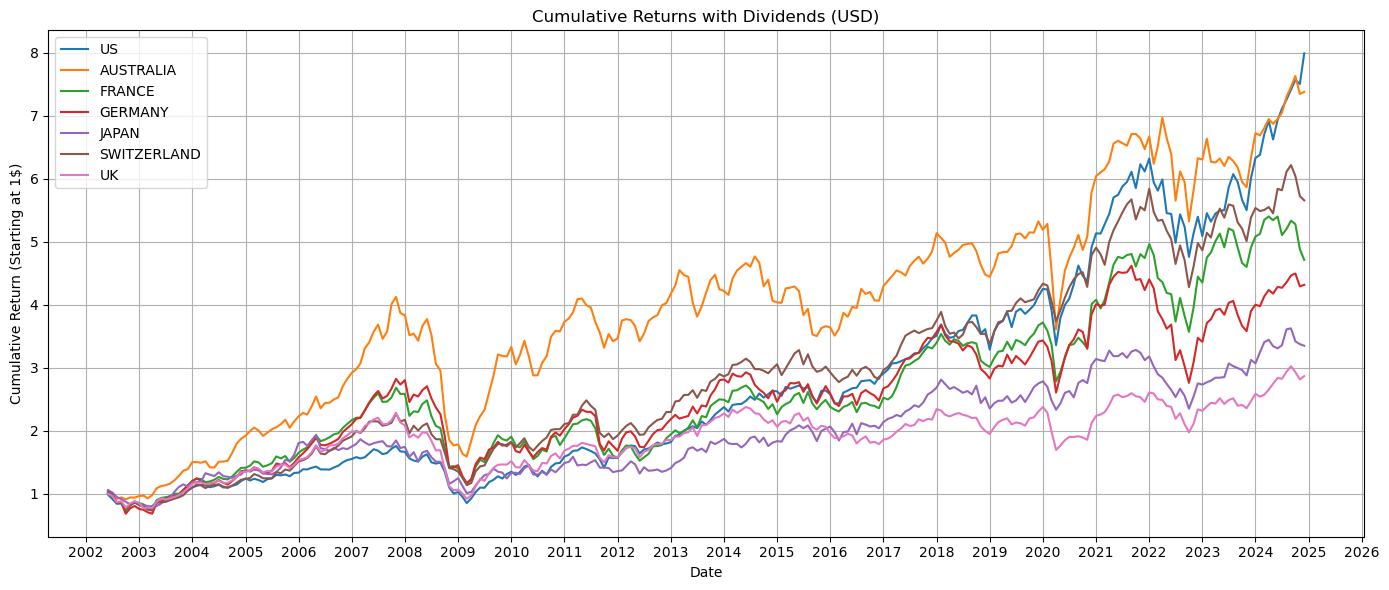

In [107]:
# Plotting the monthly returns in USD for all countries


# Import the monthly returns in USD data
df_monthly_return_usd = pd.read_csv("data/q3/monthly_returns_in_usd.csv", parse_dates=['date'], index_col='date')

# Identify columns with dividends
cols_with_div = [col for col in df_monthly_return_usd.columns if 'ret_with_div_usd' in col]

# Function to plot time series of monthly returns in 6 subplots
def plot_returns_subplots(df, cols, title):
    n = len(cols)
    nrows, ncols = 3, 3  # 7 countries → 3 rows x 3 columns

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 12), sharex=True)
    axes = axes.flatten()  # Flatten the 2D array for easy iteration

    for j in range(n, len(axes)):
        axes[j].axis('off') # Hide unused subplots

    for i, col in enumerate(cols):
        ax = axes[i]
        # Clean up the label for the title (e.g., 'uk_ret_with_div_usd' → 'Uk')
        label = col.replace('_ret_with_div_usd', '').replace('_', ' ').title().upper()
        ax.plot(df.index, df[col], label=label)
        ax.set_title(label)
        ax.grid(True)

    # Set common title and axis labels
    fig.suptitle(title, fontsize=16)
    fig.text(0.5, 0.04, "Date", ha='center', fontsize=12)
    fig.text(0.04, 0.5, "Monthly Return (USD)", va='center', rotation='vertical', fontsize=12)

    # Adjust layout to fit all elements properly
    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
    plt.show()

# Function to plot cumulative returns (compounded growth)
def plot_cumulative_returns(df, cols, title):
    plt.figure(figsize=(14, 6))
    for col in cols:
        cumulative_return = (1 + df[col]).cumprod()  # Compound monthly returns
        label = col.replace('_ret_with_div_usd', '').upper()
        plt.plot(df.index, cumulative_return, label=label)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (Starting at 1$)')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Format x-axis to show years only
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    plt.tight_layout()
    plt.savefig('data/q3/cumulative_returns_usd.png', dpi=300)
    plt.show()

# Plot monthly returns with dividends in USD
plot_returns_subplots(df_monthly_return_usd, cols_with_div, 'Monthly Returns with Dividends (USD)')

# Plot cumulative returns
plot_cumulative_returns(df_monthly_return_usd, cols_with_div, 'Cumulative Returns with Dividends (USD)')

(b) A currency-hedged index return is defined as the return in USD to a $1 investment in a foreign stock market index hedged by shorting $1 of the corresponding foreign currency.  
To be specific, the excess return in USD to a $1 investment in the Euro-currency for example (with time $t$ spot exchange rate $S_t$ USD per EUR) is:

$$
X^{EU}_{t+1} = \frac{S_{t+1}}{S_t} (1 + r^{EU}) - (1 + r^{US})
$$

It is the return to borrowing $1 at the US 3-month rate $r^{US}$, converting into $\frac{1}{S_t}$ euros, investing at the 3-month euro risk-free rate $r^{EU}$, and converting the proceeds back into dollar after one month at the then prevailing spot exchange rate $S_{t+1}$.

If the return in USD of the French index is $R^{FR}_t$, then we define the currency hedged return on the French Index in USD simply as

$$
F^{FR,US}_t = R^{FR}_t - X^{EU}_t.
$$

Compute currency hedged stock index returns.

---

The idea of the “currency hedged” return is to decompose our \$-investment return on the French stock index into the component we would have obtained investing purely in the Euro currency from the additional component of the return coming from the French equity exposure.


In [108]:
# Q3b

# Load data
df_returns_in_usd = pd.read_csv("./data/q3/monthly_returns_in_usd.csv", parse_dates=["date"], index_col='date')
df_fx_rf = pd.read_csv("data/preprocess/merged_three_month_interbank_rates.csv", parse_dates=["date"], index_col='date')
df_exchange_rates = pd.read_csv("data/preprocess/merged_exchange_rates.csv", parse_dates=["date"], index_col='date')

# Merge datasets on the date column and sort chronologically
df_hedged_returns = pd.merge(df_returns_in_usd, df_fx_rf, on="date", how="right")
df_hedged_returns = pd.merge(df_hedged_returns, df_exchange_rates, on="date", how="right")

# Map countries to relevant columns (currency, local interest rate, FX rate)
country_map = {
    "australia": {"ccy": "aud", "rate_col": "three_month_interbank_rate_AUD", "fx_col": "USD_per_AUD"},
    "france": {"ccy": "eur", "rate_col": "three_month_interbank_rate_EUR", "fx_col": "USD_per_EUR"},
    "germany": {"ccy": "eur", "rate_col": "three_month_interbank_rate_EUR", "fx_col": "USD_per_EUR"},
    "japan": {"ccy": "jpy", "rate_col": "three_month_interbank_rate_JPY", "fx_col": "USD_per_JPY"},
    "switzerland": {"ccy": "chf", "rate_col": "three_month_interbank_rate_CHF", "fx_col": "USD_per_CHF"},
    "uk": {"ccy": "gbp", "rate_col": "three_month_interbank_rate_GBP", "fx_col": "USD_per_GBP"},
}

# Extract US 3-month interbank rate from returns data
df_hedged_returns["r_us"] = df_hedged_returns["three_month_interbank_rate_USD"]

# Compute excess currency return and hedged stock index return for each country
for country, meta in country_map.items():
    ret_col = f"{country}_ret_with_div_usd"  # Local index return in USD
    fx_col = meta["fx_col"]  # Spot exchange rate: USD per 1 unit of local currency
    r_local_col = meta["rate_col"]  # Local short-term risk-free rate

    fx_t = df_hedged_returns[fx_col]                 # Spot FX rate at time t (USD per local currency)
    fx_tm1 = fx_t.shift(1)                           # Spot FX rate at time t-1
    r_local = df_hedged_returns[r_local_col]         # Local interest rate (3-month interbank rate)
    r_us = df_hedged_returns["r_us"]                 # US interest rate (3-month interbank rate)
    r_local_return = df_hedged_returns[ret_col]      # Local index return in USD
    # Currency excess return (X), following the formula:
    # X_t = (S_{t} / S_{t-1}) * (1 + r^{local}_{t-1}) - (1 + r^{us}_{t-1})
    df_hedged_returns[f"X_{country}"] = (fx_t / fx_tm1) * (1 + r_local.shift(1)) - (1 + r_us.shift(1))

    # Currency-hedged return in USD = local return - currency excess return
    # df_hedged_returns[f"{country}_local_return"] = r_local_return
    df_hedged_returns[f"{country}_hedged_return_usd"] = r_local_return - df_hedged_returns[f"X_{country}"]

# Excess return 
df_excess_returns = df_hedged_returns[["X_australia", "X_switzerland", "X_france", "X_germany", "X_uk", "X_japan"]].copy()
df_excess_returns.dropna(inplace=True)  # Drop rows with NaN values

# Save final result to CSV
df_excess_returns.to_csv("data/q3/excess_returns.csv")

# Select and export hedged return columns
hedged_cols = [col for col in df_hedged_returns.columns if col.endswith("_hedged_return_usd")]
df_hedged_returns = df_hedged_returns[hedged_cols]
df_hedged_returns.dropna(inplace=True)  # Drop rows with NaN values

# Save final result to CSV
df_hedged_returns.to_csv("data/q3/hedged_returns.csv")

# Display first few rows of the result
df_hedged_returns.head()

,australia_hedged_return_usd,france_hedged_return_usd,germany_hedged_return_usd,japan_hedged_return_usd,switzerland_hedged_return_usd,uk_hedged_return_usd
date,,,,,,
2002-06-01,-0.032030,-0.047160,-0.044748,0.054278,0.009252,-0.035688
2002-07-01,-0.057393,-0.101862,-0.089264,-0.070745,-0.079388,-0.112300
2002-08-01,-0.067738,-0.118127,-0.122877,-0.040030,-0.122092,-0.110588
2002-09-01,-0.016413,-0.020937,-0.019208,-0.007512,0.015695,-0.020161
2002-10-01,-0.071745,-0.164219,-0.220553,-0.003870,-0.077993,-0.136824


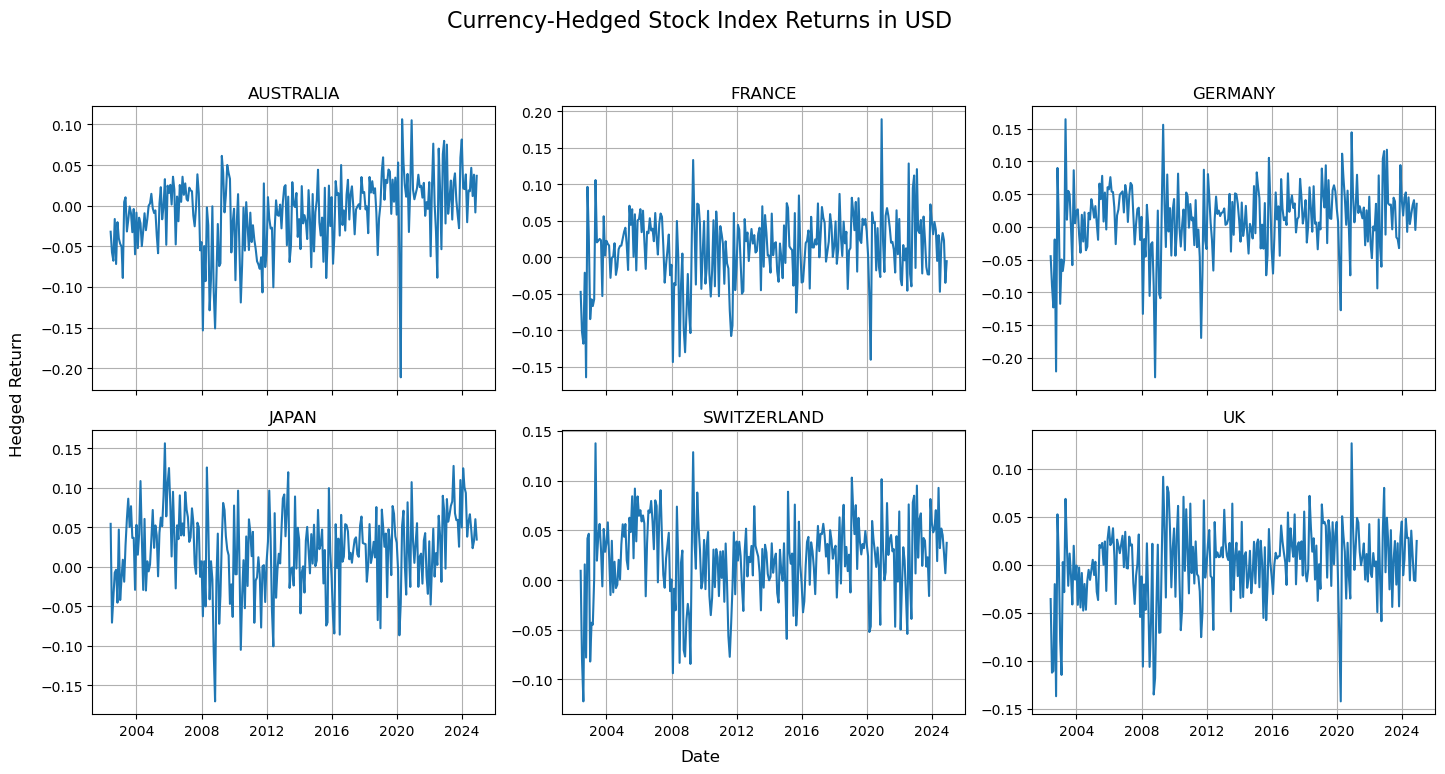

In [109]:
# Load the data
df_hedged_returns = pd.read_csv("data/q3/hedged_returns.csv", parse_dates=['date'], index_col='date')

# Create subplots: 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
axes = axes.flatten()  # Flatten the 2D array for easy indexing

# Plot each country's data
for i, country in enumerate(country_map.keys()):
    ax = axes[i]
    hedged_col = f"{country}_hedged_return_usd"
    
    if hedged_col in df_hedged_returns.columns:
        ax.plot(df_hedged_returns.index, df_hedged_returns[hedged_col])
        ax.set_title(country.upper())
        ax.grid(True)

# Common labels and layout adjustments
fig.suptitle("Currency-Hedged Stock Index Returns in USD", fontsize=16)
fig.text(0.5, 0.04, "Date", ha='center', fontsize=12)
fig.text(0.04, 0.5, "Hedged Return", va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()

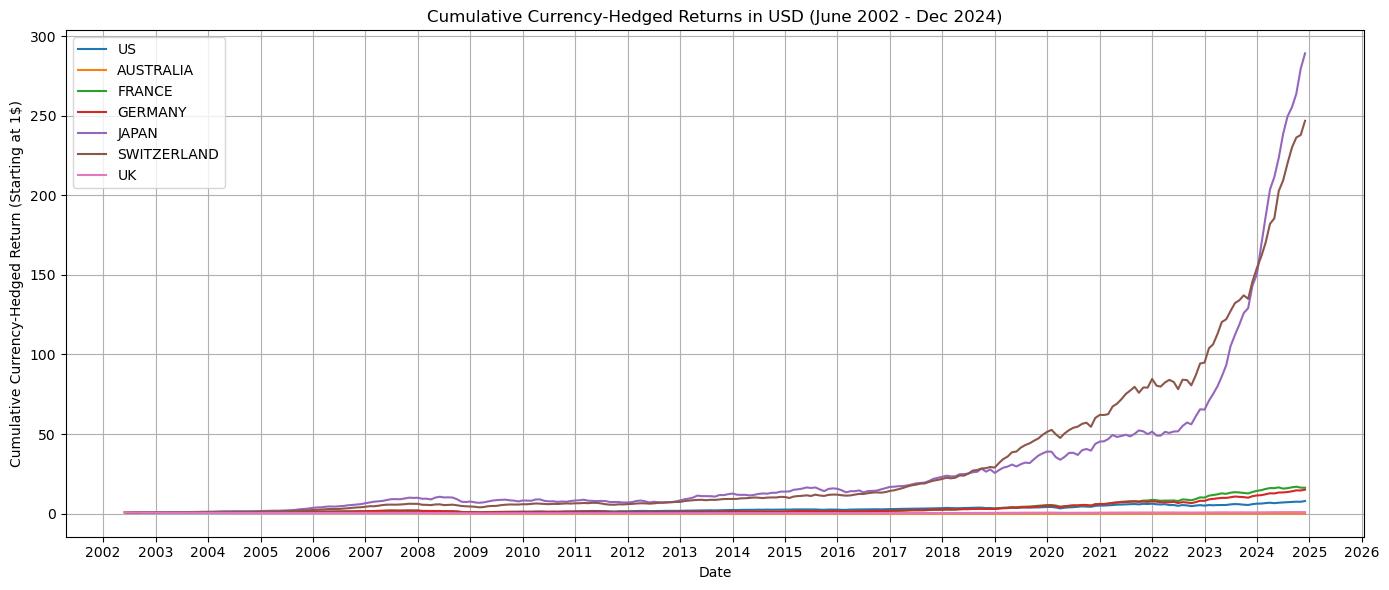

In [110]:
df_hedged_returns_extended = df_hedged_returns.copy()

df_hedged_returns_extended = pd.merge(
    df_monthly_return_usd[['us_ret_with_div_usd']],
    df_hedged_returns,
    left_index=True,
    right_index=True,
    how='inner'
)

plt.figure(figsize=(14, 6))
for col in df_hedged_returns_extended.columns:
    cumulative_return = (1 + df_hedged_returns_extended[col]).cumprod()  # Compound monthly returns
    label = col.replace('_ret_with_div_usd', '').replace('_hedged_return_usd', '').upper()
    plt.plot(df_hedged_returns_extended.index, cumulative_return, label=label)

plt.title("Cumulative Currency-Hedged Returns in USD (June 2002 - Dec 2024)")
plt.xlabel('Date')
plt.ylabel('Cumulative Currency-Hedged Return (Starting at 1$)')
plt.legend(loc='upper left')
plt.grid(True)

# Format x-axis to show years only
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.savefig('data/q3/cumulative_hedged_returns_usd.png', dpi=300)
plt.show()

(c) Consider three different approaches for a US investor to diversify internationally:

- Equal weight the indexes.
- Risk-Parity based on a 60 months rolling window estimate of the strategy returns volatilities. Going forward, use a rolling window of 60 months each time you are asked to use a rolling window.
- Mean-variance optimal combination based on the rolling window mean and covariance matrix of the strategy returns.

For each of the three approaches to combining the strategies compute the overall mean, standard deviation, and Sharpe ratio of the resulting ‘optimal’ portfolio. Compare the case where you use unhedged returns and currency hedged returns. What is your conclusion regarding the benefits of international diversification for a US investor?


In [111]:
#Q3c
# Methods to compute all the required portfolios 

# Portfolio where every country is equally weighted
def equal_weighted(returns: pd.DataFrame, rf_series: pd.Series):
    nb_countries = returns.shape[1]
    return_a = (returns * (1 / nb_countries)).sum(axis=1)
    mean_a = 12*return_a.mean()
    std_a = np.sqrt(12)*return_a.std()
    sharpe_a = (mean_a - 12*rf_series.mean()) / std_a

    print("EQUALLY WEIGHTED : ")
    print(f"Mean return : {mean_a}")
    print(f"Standard deviation : {std_a}")
    print(f"Sharpe ratio : {sharpe_a}\n")

# Portfolio where every weight is inversely proportional to the volatility
def risk_parity(returns: pd.DataFrame, rf_series: pd.Series):
    # Shift by 1 to compute weights of time t with data until t-1
    rolling_vol = returns.rolling(window=60).std().shift(1).dropna()
    inv_vol = 1 / rolling_vol
    weights = inv_vol.div(inv_vol.sum(axis=1), axis=0).dropna()
    returns_aligned = returns.loc[weights.index]
    return_b = (weights * returns_aligned).sum(axis=1).dropna()
    mean_b = 12*return_b.mean()
    std_b = np.sqrt(12)*return_b.std()
    sharpe_b = (mean_b - 12*rf_series.mean()) / std_b

    print("RISK-PARITY : ")
    print(f"Mean return : {mean_b}")
    print(f"Standard deviation : {std_b}")
    print(f"Sharpe ratio : {sharpe_b}\n")

    return return_b.to_frame()

# Optimal mean-variance portfolio 
def mean_variance(returns: pd.DataFrame, rf_series: pd.Series):
    rolling_mean = returns.rolling(window=60).mean().dropna()
    rolling_cov = returns.rolling(window=60).cov().dropna()

    mv_weights = []
    dates_mv = rolling_mean.index
    columns = returns.columns

    for date in dates_mv:
        mu = rolling_mean.loc[date]
        Sigma = rolling_cov.loc[date]
        rf = rf_series.loc[date]
        excess = mu - rf
        w = inv(Sigma) @ excess
        mv_weights.append(w)

    # Shift by 1 to compute weights of time t with data until t-1
    mv_weights_df = pd.DataFrame(mv_weights, index=dates_mv, columns=columns).shift(1)
    returns_aligned_mv = returns.loc[mv_weights_df.index]
    weighted_returns = mv_weights_df * returns_aligned_mv
    return_c = (weighted_returns).sum(axis=1)
    mean_c = 12*return_c.mean()
    std_c = np.sqrt(12)*return_c.std()
    sharpe_c = (mean_c - 12*rf_series.mean()) / std_c

    print("MEAN-VARIANCE OPTIMAL:")
    print(f"Mean return : {mean_c}")
    print(f"Standard deviation : {std_c}")
    print(f"Sharpe ratio : {sharpe_c} ")

In [112]:
#Q3c
# Hedged returns case

inter_hedged = df_hedged_returns
# Manually add the US returns
inter_hedged["us_ret_with_div_usd"] = df_monthly_return_usd["us_ret_with_div_usd"]

# Print the mean, volaility and Sharpe ratio 
print("HEDGED RETURNS : \n")
equal_weighted(inter_hedged, df_tbills["rf"])
div_return = risk_parity(inter_hedged, df_tbills["rf"])
mean_variance(inter_hedged, df_tbills["rf"])

HEDGED RETURNS : 

EQUALLY WEIGHTED : 
Mean return : 0.11506612717868328
Standard deviation : 0.13909803369360837
Sharpe ratio : 0.7195831250022758

RISK-PARITY : 
Mean return : 0.10724727139795548
Standard deviation : 0.13988019275502017
Sharpe ratio : 0.6596626739555244

MEAN-VARIANCE OPTIMAL:
Mean return : 22.051821442364393
Standard deviation : 7.395961726131735
Sharpe ratio : 2.979578414405671 


In [113]:
#Q3c
# Unhedged returns case

inter_unhedged = df_monthly_return_usd

# Print the mean, volatility and Sharpe ratio 
print("UNHEDGED RETURNS : \n")
equal_weighted(inter_unhedged, df_tbills["rf"])
risk_parity(inter_unhedged, df_tbills["rf"])
mean_variance(inter_unhedged, df_tbills["rf"])

UNHEDGED RETURNS : 

EQUALLY WEIGHTED : 
Mean return : 0.08559953598670879
Standard deviation : 0.15283468252729818
Sharpe ratio : 0.46210719587374677

RISK-PARITY : 
Mean return : 0.060132310341311127
Standard deviation : 0.15515745288467353
Sharpe ratio : 0.2910513165172436

MEAN-VARIANCE OPTIMAL:
Mean return : 0.6088262341683365
Standard deviation : 1.9959235995399092
Sharpe ratio : 0.2975327837666051 


(d) Going forward we define the DIV strategy as the return to the currency hedged, risk-parity strategy. We will now consider a number of dynamic portfolio strategies and investigate whether they can improve on the simple DIV strategy.


In [114]:
# Q3d: div_return stores the returns needed for next exercises in a .csv file 
div_return = div_return.rename(columns={0:"DIV_return"})
div_return.to_csv("data/q3/div_return.csv")

# 4 Equity Index Momentum Strategy (MOM)

(a) Construct the return to a long-short momentum strategy portfolio. To that effect, every month sort currency hedged stock indexes based on their 1-month lagged 11-month return (that is in month $t$ rank stocks based on their $t-12$ to $t-1$ cumulative return). Call $\text{Rank}^i_t$ the corresponding rank of index $i$ at time $t$ (e.g., $\text{Rank}^i_t = 2$ if country $i$ has the second lowest currency-hedged return over the last year).

Then compute monthly returns to a portfolio that invests in index $i$ the weight

$$
w^i_t = Z \left(\text{Rank}^i_t - \frac{N+1}{2}\right)
$$

for all $i = 1, \ldots, N$, where $N$ is the total number of stock indexes traded and $Z$ is a factor that ensures that the sum of the long positions is +\$1 and the sum of the short positions is -\$1.


In [115]:
df_hedged_returns = pd.read_csv("data/q3/hedged_returns.csv")
df_hedged_returns.set_index('date', inplace=True)

df_return_with_div = pd.read_csv("data/preprocess/merged_returns_with_dividends.csv")
df_return_with_div.set_index('date', inplace=True)

df = df_hedged_returns.rename(columns={
    "australia_hedged_return_usd":   "AUS",
    "france_hedged_return_usd":      "FRA",
    "germany_hedged_return_usd":     "GER",
    "japan_hedged_return_usd":       "JPN",
    "switzerland_hedged_return_usd": "SWI",
    "uk_hedged_return_usd":          "UK"
})

df['US'] = df_return_with_div["us_ret_with_div_usd"]

# Convert the 'date' column to datetime format and shift to the first day of the next month
df_tbills = pd.read_csv('data/preprocess/tbills.csv')
df_tbills.set_index('date', inplace=True)

# To match the hedged return we drop the first row
tbill = df_tbills.rename(columns={"rf": "TBill1Mo"})["TBill1Mo"].iloc[1:]


div_df = pd.read_csv("data/q3/div_return.csv")
div_df.set_index('date', inplace=True)
div = div_df["DIV_return"]   


one_plus = 1.0 + df

In [116]:
# Helper to compute annualized mean, vol, and Sharpe
def annualized_stats(returns, rf = None, period = 12, zero_cost = False):
    """
    Given two pandas Series of monthly returns (decimal):
      - returns: strategy returns
      - rf:      risk-free returns
    Returns (annualized_mean, annualized_vol, annualized_sharpe).
    """
    mean_annual_return = period * returns.mean()
    std_annual_return = np.sqrt(period) * returns.std()
    if zero_cost:
        return mean_annual_return, std_annual_return, (mean_annual_return/std_annual_return)
    rf_annual = period * rf.mean()
    excess_ret = mean_annual_return - rf_annual
    sharpe_ratio = excess_ret / std_annual_return
    return mean_annual_return, std_annual_return, sharpe_ratio

In [117]:
# Q4a)

# Compute 11-month lookback cumulative return, then shift by 1 to impose 1-month lag:
cumprod_11 = one_plus.rolling(window=12).apply(np.prod).shift(1) - 1

# Rank each row (month) ascending
ranks_11 = cumprod_11.rank(axis=1, method="first", ascending=True)

# Compute scaling factor Z so that ∑_{i: w>0} w = +1 and ∑_{i: w<0} w = -1.
N_mom = 7             
mean_rank_mom = (N_mom + 1) / 2.0   

# Compute MOM weights
raw_w_mom = (ranks_11 - mean_rank_mom)
Z =   1.0 / 6.0
w_mom = raw_w_mom * Z

# Strategy return at month 
mom_ret = (w_mom * df).sum(axis=1, skipna=False)

# Decompose the “long leg” (w>0) and “short leg” (w<0) returns:
long_w_mom  = w_mom.clip(lower=0)
short_w_mom = w_mom.clip(upper=0)

mom_long_ret  = (long_w_mom  * df).sum(axis=1, skipna=False)
mom_short_ret = (short_w_mom * df).sum(axis=1, skipna=False)

# Align with T-Bill series, drop NaNs (the first 12 months) for clean statistics:
mom_df = pd.DataFrame({
    "MOM":   mom_ret,
    "LONG":  mom_long_ret,
    "SHORT": mom_short_ret,   
    "TBill": tbill
}).dropna()


(b) Compute and compare the mean, standard deviation, and Sharpe ratios of the long and short legs of the strategy as well as of the strategy itself. Test if the strategy has an average return that is statistically significantly different from zero.


In [118]:
# b)

mean_mom, sigma_mom, sharpe_mom = annualized_stats(mom_df["MOM"], zero_cost=True)
mean_mL,  sigma_mL,  sharpe_mL  = annualized_stats(mom_df["LONG"], rf = mom_df["TBill"])
mean_mS,  sigma_mS,  sharpe_mS  = annualized_stats(mom_df["SHORT"], rf = mom_df["TBill"])

# One-sample t-test: H0: mean(MOM) = 0
t_stat_mom, p_val_mom = stats.ttest_1samp(mom_df["MOM"], popmean=0.0)

print("=== MOMENTUM (MOM) Strategy Statistics ===")
print(f"Overall MOM: Annualized Return = {mean_mom:.2%}, "
      f"Volatility = {sigma_mom:.2%}, Sharpe = {sharpe_mom:.2f}")
print(f"MOM Long Leg: Annualized Return = {mean_mL:.2%}, "
      f"Volatility = {sigma_mL:.2%}, Sharpe = {sharpe_mL:.2f}")
print(f"MOM Short Leg: Annualized Return = {mean_mS:.2%}, "
      f"Volatility = {sigma_mS:.2%}, Sharpe = {sharpe_mS:.2f}")
print(f"MOM mean-return t-stat = {t_stat_mom:.3f}, p-value = {p_val_mom:.3f}\n")

alpha = 0.05  # typical significance level
if p_val_mom < alpha:
    print("The strategy's mean return is significantly different from zero.")
else:
    print("The strategy's mean return is not significantly different from zero.")


mom_df['MOM'].to_csv('data/q4/mom_return.csv')

=== MOMENTUM (MOM) Strategy Statistics ===
Overall MOM: Annualized Return = 27.58%, Volatility = 8.14%, Sharpe = 3.39
MOM Long Leg: Annualized Return = 26.26%, Volatility = 13.98%, Sharpe = 1.77
MOM Short Leg: Annualized Return = 1.32%, Volatility = 13.67%, Sharpe = -0.01
MOM mean-return t-stat = 15.751, p-value = 0.000

The strategy's mean return is significantly different from zero.


(c) Regress the MOM strategy return on the DIV return. Interpret the regression results. In particular, do you think that it is interesting for a DIV-investor to also invest in the MOM strategy?


In [119]:
# Q4c)

# Regress MOM on DIV (Newey-West errors, lag=1)
reg_mom_div = pd.DataFrame({
    "MOM": mom_ret.iloc[48:],
    "DIV": div
}).dropna()

X_m = sm.add_constant(reg_mom_div["DIV"])
y_m = reg_mom_div["MOM"]
mom_on_div = sm.OLS(y_m, X_m).fit()

print(">>> Regression of MOM on DIV:")
print(mom_on_div.summary())
print("\n")

>>> Regression of MOM on DIV:
                            OLS Regression Results                            
Dep. Variable:                    MOM   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7791
Date:                Sun, 15 Jun 2025   Prob (F-statistic):              0.378
Time:                        15:31:29   Log-Likelihood:                 500.05
No. Observations:                 211   AIC:                            -996.1
Df Residuals:                     209   BIC:                            -989.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0193 

# 5 Equity Index Long Term Reversal strategy (REV)

(a) Construct the return to a long-short reversal strategy portfolio. To that effect every month sort currency hedged stock indexes based on their 12-month lagged 5-year past return (that is in month $t$ rank stocks based on their $t-60$ to $t-12$ cumulative return). Call $\text{Rank}^i_t$ the corresponding rank of index $i$ at time $t$.

Then compute monthly returns to a portfolio that invests in index $i$ the weight:

$$
w^i_t = Z \left(\frac{N+1}{2} - \text{Rank}^i_t \right)
$$

for all $i = 1, \ldots, N$, where $N$ is the total number of stock indexes traded and $Z$ is a factor that ensures that the sum of the long positions is +\$1 and the sum of the short positions is -\$1.

---

Note that we go long stocks with low long-term past returns. This is a reversal strategy akin to a ‘value’
signal. It would be preferable to sort on average valuation ratios such as the Shiller PE ratio. But to simplify
the data-collection we focus on this reversal proxy.

In [120]:
# Q5a)

# Compute rolling 60-month product and rolling 12-month product:
rolling48 = one_plus.rolling(window=60).apply(lambda x: np.prod(x[:-11])).shift(1) - 1

# Rank each month ascending 
ranks_48 = rolling48.rank(axis=1, method="first", ascending=True)

# Compute scaling factor Z so that ∑_{i: w>0} w = +1 and ∑_{i: w<0} w = -1.
N_rev = 7            
mean_rank_rev = (N_rev + 1) / 2.0    

# Compute MOM weights
raw_w_rev = (mean_rank_rev - ranks_48)
Z = 1.0 / 6.0
w_rev = Z * raw_w_rev

# Strategy return at t: sum_i [ w_rev[i,t] * df[i,t] ]
rev_ret = (w_rev * df).sum(axis=1, skipna=False)

# Decompose “long leg” and “short leg” for REV:
long_w_rev  = w_rev.clip(lower=0)
short_w_rev = w_rev.clip(upper=0)
rev_long_ret  = (long_w_rev  * df).sum(axis=1, skipna=False)
rev_short_ret = (short_w_rev * df).sum(axis=1, skipna=False)

# Align with T-Bill, drop NaNs (the first 60 months):
rev_df = pd.DataFrame({
    "REV":   rev_ret,
    "LONG":  rev_long_ret,
    "SHORT": rev_short_ret,
    "TBill": tbill
}).dropna()

(b) Compute and compare the mean, standard deviation, and Sharpe ratios of the long and short legs of the strategy as well as of the strategy itself. Test if the strategy has an average return that is statistically significantly different from zero.


In [121]:
# Q5b) 

mean_rev, sigma_rev, sharpe_rev = annualized_stats(rev_df["REV"], zero_cost=True)
mean_rL,  sigma_rL,  sharpe_rL  = annualized_stats(rev_df["LONG"], rf = rev_df["TBill"])
mean_rS,  sigma_rS,  sharpe_rS  = annualized_stats(rev_df["SHORT"], rf = rev_df["TBill"])

# One-sample t-test for REV mean
t_stat_rev, p_val_rev = stats.ttest_1samp(rev_df["REV"], popmean=0.0)

print("=== REVERSAL (REV) Strategy Statistics ===")
print(f"Overall REV: Annualized Return = {mean_rev:.2%}, "
      f"Volatility = {sigma_rev:.2%}, Sharpe = {sharpe_rev:.2f}")
print(f"REV Long Leg: Annualized Return = {mean_rL:.2%}, "
      f"Volatility = {sigma_rL:.2%}, Sharpe = {sharpe_rL:.2f}")
print(f"REV Short Leg: Annualized Return = {mean_rS:.2%}, "
      f"Volatility = {sigma_rS:.2%}, Sharpe = {sharpe_rS:.2f}")
print(f"REV mean-return t-stat = {t_stat_rev:.3f}, p-value = {p_val_rev:.3f}\n")

alpha = 0.05  # typical significance level

if p_val_rev < alpha:
    print("The strategy's mean return is significantly different from zero.")
else:
    print("The strategy's mean return is not significantly different from zero.")

rev_df['REV'].to_csv('data/q5/rev_return.csv')

=== REVERSAL (REV) Strategy Statistics ===
Overall REV: Annualized Return = -20.55%, Volatility = 7.45%, Sharpe = -2.76
REV Long Leg: Annualized Return = -1.27%, Volatility = 14.37%, Sharpe = -0.17
REV Short Leg: Annualized Return = -19.28%, Volatility = 14.04%, Sharpe = -1.46
REV mean-return t-stat = -11.567, p-value = 0.000

The strategy's mean return is significantly different from zero.


(c) Regress the REV strategy return on the DIV return. Interpret the regression results. In particular, do you think that it is interesting for a DIV-investor to also invest in the REV strategy?


In [122]:
# Q5c)

# Regress REV on DIV (Newey-West lag=1)
reg_rev_div = pd.DataFrame({
    "REV": rev_ret,
    "DIV": div
}).dropna()

X_r = sm.add_constant(reg_rev_div["DIV"])
y_r = reg_rev_div["REV"]
rev_on_div = sm.OLS(y_r, X_r).fit()

print(">>> Regression of REV on DIV:")
print(rev_on_div.summary())

>>> Regression of REV on DIV:
                            OLS Regression Results                            
Dep. Variable:                    REV   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.4703
Date:                Sun, 15 Jun 2025   Prob (F-statistic):              0.494
Time:                        15:31:29   Log-Likelihood:                 511.43
No. Observations:                 211   AIC:                            -1019.
Df Residuals:                     209   BIC:                            -1012.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0174 

# 6 Currency Carry Strategy (CARRY)

(a) Construct the return to a long-short currency carry strategy portfolio. To that effect, every month sort currency returns based on their interest rate differential (i.e., the ‘carry’ is defined as the foreign risk-free 3-month interest rate minus the 3-month USD risk-free rate). Call $\text{Rank}^i_t$ the corresponding rank of index $i$ at time $t$.

Then compute monthly returns to a portfolio that invests in index $i$ the weight

$$
w^i_t = Z \left(\text{Rank}^i_t - \frac{N+1}{2}\right)
$$

for all $i=1, \ldots, N$, where $N$ is the total number of currencies traded and $Z$ is a factor that ensures that the sum of the long positions is +\$1 and the sum of the short positions is -\$1$. Its return is then:

$$
R^{CARRY}_{t+1} = \sum_{i=1}^N w^i_t X^i_{t+1}
$$

where $X^i_{t+1}$ is given by equation

$$
X^{EU}_{t+1} = \frac{S_{t+1}}{S_t} (1 + r^{EU}) - (1 + r^{US})
$$

from part 3.


In [123]:
# Q6a

df_returns = pd.read_csv('data/preprocess/merged_three_month_interbank_rates.csv')
df_returns.set_index('date', inplace=True)
df_returns.head()

# add carry columns (foreign return - usd return)
df_returns['carry_AUD'] = df_returns['three_month_interbank_rate_AUD'] - df_returns['three_month_interbank_rate_USD']
df_returns['carry_CHF'] = df_returns['three_month_interbank_rate_CHF'] - df_returns['three_month_interbank_rate_USD']
df_returns['carry_EUR'] = df_returns['three_month_interbank_rate_EUR'] - df_returns['three_month_interbank_rate_USD']
df_returns['carry_GBP'] = df_returns['three_month_interbank_rate_GBP'] - df_returns['three_month_interbank_rate_USD']
df_returns['carry_JPY'] = df_returns['three_month_interbank_rate_JPY'] - df_returns['three_month_interbank_rate_USD']


# create a new dataframe with carry returns
df_carry = df_returns[['carry_AUD', 'carry_CHF', 'carry_EUR', 'carry_GBP', 'carry_JPY']].copy()

# Convert the 'date' column to datetime format and shift to the first day of the next month
df_tbills = pd.read_csv('data/preprocess/tbills.csv')
df_tbills.set_index('date', inplace=True)

# To match the hedged return we drop the first row
tbill = df_tbills.rename(columns={"rf": "TBill1Mo"})["TBill1Mo"].iloc[1:]

div_df = pd.read_csv("data/q3/div_return.csv")
div_df.set_index('date', inplace=True)
div = div_df["DIV_return"] 

In [124]:
# extract the rank of each currency's carry return
# for simplicity, we sort by date, drop the date, rank, and add the date back
df_rank = df_carry.rank(axis=1, method="first", ascending=True)

# calculate weights based on shifted ranks w_i = rank_i - (N + 1) / 2
N = 5 # Number of currency         
mean_rank_curr = (N + 1) / 2.0 

# Compute MOM weights
raw_w_curr = (df_rank - mean_rank_curr)
Z = 8.0 / 24.0
w_curr = Z * raw_w_curr

print("finale \n", w_curr.head())
w_curr.rename(columns={"carry_AUD":"norm_weights_AUD", 
                       "carry_CHF":"norm_weights_CHF", 
                       "carry_EUR":"norm_weights_EUR", 
                       "carry_GBP":"norm_weights_GBP", 
                       "carry_JPY":"norm_weights_JPY"}).to_csv("data/q6/norm_weights.csv")

finale 
             carry_AUD  carry_CHF  carry_EUR  carry_GBP  carry_JPY
date                                                             
2002-05-01   0.666667  -0.333333        0.0   0.333333  -0.666667
2002-06-01   0.666667  -0.333333        0.0   0.333333  -0.666667
2002-07-01   0.666667  -0.333333        0.0   0.333333  -0.666667
2002-08-01   0.666667  -0.333333        0.0   0.333333  -0.666667
2002-09-01   0.666667  -0.333333        0.0   0.333333  -0.666667


In [125]:
df_excess_return = pd.read_csv("data/q3/excess_returns.csv")
df_excess_return.set_index('date', inplace=True)

# France and Germany are the same
df = df_excess_return.drop(columns = ['X_germany'])

# Drop the first row because X_t+1 and rename for product
w_curr = w_curr.iloc[1:]
dummy_w = w_curr.rename(columns={"carry_AUD":"X_australia", 
                       "carry_CHF":"X_switzerland", 
                       "carry_EUR":"X_france", 
                       "carry_GBP":"X_uk", 
                       "carry_JPY":"X_japan"})

carry_ret = (dummy_w * df).sum(axis=1, skipna=False)

# Decompose the “long leg” (w>0) and “short leg” (w<0) returns:
long_w_carry  = dummy_w.clip(lower=0)
short_w_carry = dummy_w.clip(upper=0)

carry_long_ret  = (long_w_carry  * df).sum(axis=1, skipna=False)
carry_short_ret = (short_w_carry * df).sum(axis=1, skipna=False)

# Align with T-Bill series, drop NaNs (the first 12 months) for clean statistics:
carry_df = pd.DataFrame({
    "CARRY": carry_ret,
    "LONG":  carry_long_ret,
    "SHORT": carry_short_ret,   
    "TBill": tbill
}).dropna()

(b) Compute and compare the mean, standard deviation, and Sharpe ratios of the long and short legs of the strategy as well as of the strategy itself. Test if the strategy has an average return that is statistically significantly different from zero.


In [126]:
# Q6b
# Helper to compute annualized mean, vol, and Sharpe
def annualized_stats(returns, rf = None, period = 12, zero_cost = False):
    """
    Given two pandas Series of monthly returns (decimal):
      - returns: strategy returns
      - rf:      risk-free returns
    Returns (annualized_mean, annualized_vol, annualized_sharpe).
    """
    mean_annual_return = period * returns.mean()
    std_annual_return = np.sqrt(period) * returns.std()
    if zero_cost:
        return mean_annual_return, std_annual_return, (mean_annual_return/std_annual_return)
    rf_annual = period * rf.mean()
    excess_ret = mean_annual_return - rf_annual
    sharpe_ratio = excess_ret / std_annual_return
    return mean_annual_return, std_annual_return, sharpe_ratio

mean_carry, sigma_carry, sharpe_carry = annualized_stats(carry_df["CARRY"], zero_cost=True)
mean_mL,  sigma_mL,  sharpe_mL  = annualized_stats(carry_df["LONG"], rf = carry_df["TBill"])
mean_mS,  sigma_mS,  sharpe_mS  = annualized_stats(carry_df["SHORT"], rf = carry_df["TBill"])

# One-sample t-test: H0: mean(CARRY) = 0
t_stat_mom, p_val_mom = stats.ttest_1samp(carry_df["CARRY"], popmean=0.0)

print("=== CARRY Strategy Statistics ===")
print(f"Overall CARRY: Annualized Return = {mean_carry:.2%}, "
      f"Volatility = {sigma_carry:.2%}, Sharpe = {sharpe_carry:.2f}")
print(f"CARRY Long Leg: Annualized Return = {mean_mL:.2%}, "
      f"Volatility = {sigma_mL:.2%}, Sharpe = {sharpe_mL:.2f}")
print(f"CARRY Short Leg: Annualized Return = {mean_mS:.2%}, "
      f"Volatility = {sigma_mS:.2%}, Sharpe = {sharpe_mS:.2f}")
print(f"CARRY mean-return t-stat = {t_stat_mom:.3f}, p-value = {p_val_mom:.3f}\n")

alpha = 0.05  # typical significance level
if p_val_mom < alpha:
    print("The strategy's mean return is significantly different from zero.")
else:
    print("The strategy's mean return is not significantly different from zero.")


carry_df['CARRY'].to_csv('data/q6/carry_returns.csv')

# TODO plot long leg vs short legs vs strategy, compare results (seem strange), test if strat is statistically significantly different from long 0

=== CARRY Strategy Statistics ===
Overall CARRY: Annualized Return = 36.69%, Volatility = 8.91%, Sharpe = 4.12
CARRY Long Leg: Annualized Return = 16.97%, Volatility = 9.78%, Sharpe = 1.58
CARRY Short Leg: Annualized Return = 19.73%, Volatility = 9.00%, Sharpe = 2.03
CARRY mean-return t-stat = 19.579, p-value = 0.000

The strategy's mean return is significantly different from zero.


(c) Regress the CARRY strategy return on the DIV return. Interpret the regression results. In particular, do you think that it is interesting for a DIV-investor to also invest in the CARRY strategy?


In [127]:
# Q6 c

# Regress CARRY on DIV (Newey-West errors, lag=1)
reg_mom_div = pd.DataFrame({
    "CARRY": carry_ret.iloc[60:],
    "DIV": div
}).dropna()

X_m = sm.add_constant(reg_mom_div["DIV"])
y_m = reg_mom_div["CARRY"]
carry_on_div = sm.OLS(y_m, X_m).fit()

print(">>> Regression of CARRY on DIV:")
print(carry_on_div.summary())
print("\n")

>>> Regression of CARRY on DIV:
                            OLS Regression Results                            
Dep. Variable:                  CARRY   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.542
Date:                Sun, 15 Jun 2025   Prob (F-statistic):              0.112
Time:                        15:31:30   Log-Likelihood:                 484.62
No. Observations:                 211   AIC:                            -965.2
Df Residuals:                     209   BIC:                            -958.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.023

# 7 Currency Dollar Strategy (DOLLAR)

(a) Construct the return to a long-dollar versus rest of the world strategy portfolio. That portfolio simply goes short an equal weighted basket of all the foreign currencies against the dollar. Its return is then simply:

$$
R^{DOLLAR}_{t+1} = \frac{1}{N} \sum_{i=1}^N X^i_{t+1}
$$

where $X^i_{t+1}$ is the excess return on currency $i$ (as computed in equation

$$
X^{EU}_{t+1} = \frac{S_{t+1}}{S_t} (1 + r^{EU}) - (1 + r^{US})
$$

), and $N$ denotes the total number of foreign currencies traded.


In [128]:
df_excess_return = pd.read_csv("data/q3/excess_returns.csv")
df_excess_return.set_index('date', inplace=True)

# France and Germany are the same
df = df_excess_return.drop(columns = ['X_germany'])

div_df = pd.read_csv("data/q3/div_return.csv")
div_df.set_index('date', inplace=True)
div = div_df["DIV_return"] 

In [129]:
# Q7a

N = 5 # Number of foreign currency traded

# France and Germany are the same
df = df_excess_return.drop(columns = ['X_germany'])

dollar_ret = - (1/N) * df.sum(axis = 1)

dollar_df = pd.DataFrame({
    "DOLLAR": dollar_ret,
}).dropna()

# TODO plot evolution of return and verify data on countries (not currency) is correct

(b) Compute and compare the mean, standard deviation, and Sharpe ratios of the strategy. Test if the strategy has an average return that is statistically significantly different from zero.


In [130]:
# Q7 b
def annualized_stats(returns, rf = None, period = 12, zero_cost = False):
    """
    Given two pandas Series of monthly returns (decimal):
      - returns: strategy returns
      - rf:      risk-free returns
    Returns (annualized_mean, annualized_vol, annualized_sharpe).
    """
    mean_annual_return = period * returns.mean()
    std_annual_return = np.sqrt(period) * returns.std()
    if zero_cost:
        return mean_annual_return, std_annual_return, (mean_annual_return/std_annual_return)
    rf_annual = period * rf.mean()
    excess_ret = mean_annual_return - rf_annual
    sharpe_ratio = excess_ret / std_annual_return
    return mean_annual_return, std_annual_return, sharpe_ratio

mean_dollar, sigma_dollar, sharpe_dollar = annualized_stats(dollar_df["DOLLAR"], zero_cost=True)

# One-sample t-test: H0: mean(CARRY) = 0
t_stat_mom, p_val_mom = stats.ttest_1samp(dollar_df["DOLLAR"], popmean=0.0)

print("=== DOLLAR Strategy Statistics ===")
print(f"Long USD vs World Return: Annualized Return = {mean_dollar:.2%}, "
      f"Volatility = {sigma_dollar:.2%}, Sharpe = {sharpe_dollar:.2f}")

print(f"DOLLAR mean-return t-stat = {t_stat_mom:.3f}, p-value = {p_val_mom:.3f}\n")

alpha = 0.05  # typical significance level
if p_val_mom < alpha:
    print("The strategy's mean return is significantly different from zero.")
else:
    print("The strategy's mean return is not significantly different from zero.")

dollar_df['DOLLAR'].to_csv('data/q7/USD_vs_World.csv')

# TODO compare, test if average return is statistically significantly different from 0

=== DOLLAR Strategy Statistics ===
Long USD vs World Return: Annualized Return = 3.08%, Volatility = 7.74%, Sharpe = 0.40
DOLLAR mean-return t-stat = 1.892, p-value = 0.060

The strategy's mean return is not significantly different from zero.


(c) Regress the DOLLAR strategy return on the DIV return. Interpret the regression results. In particular, do you think that it is interesting for a DIV-investor to also invest in the DOLLAR strategy?


In [131]:
# Q7 c
# Regress CARRY on DIV (Newey-West errors, lag=1)
reg_mom_div = pd.DataFrame({
    "DOLLAR": dollar_ret.iloc[60:],
    "DIV": div
}).dropna()

X_m = sm.add_constant(reg_mom_div["DIV"])
y_m = reg_mom_div["DOLLAR"]
dollar_on_div = sm.OLS(y_m, X_m).fit()

print(">>> Regression of DOLLAR on DIV:")
print(dollar_on_div.summary())
print("\n")

>>> Regression of DOLLAR on DIV:
                            OLS Regression Results                            
Dep. Variable:                 DOLLAR   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.4357
Date:                Sun, 15 Jun 2025   Prob (F-statistic):              0.510
Time:                        15:31:30   Log-Likelihood:                 515.83
No. Observations:                 211   AIC:                            -1028.
Df Residuals:                     209   BIC:                            -1021.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.00

# 8 Optimal Fund Portfolio Return (STRAT)

(a) We now assume that you are running a fund that is currently investing in the 1-month T-Bill and the diversified stock-index strategy (DIV). That is your current (FUND) strategy has return

$$
R_{\text{FUND}} = R_{\text{T-Bill}} + a (R_{\text{DIV}} - R_{\text{T-Bill}})
$$

where $a$ is chosen so that the annualized volatility of your fund return is 15% (over the past history available). Find $a$.

You are considering adding an ‘overlay’ investment in the dynamic stock index strategies (MOM, REV) and the currency strategies (CARRY, DOLLAR) targeting an average annual volatility for your fund of 15%.

Specifically, consider the return to the fund to be

$$
R_{\text{FUND}} = R_{\text{T-Bill}} + b \times (R_{\text{DIV}} - R_{\text{T-Bill}}) + c \times R_{\text{STRAT}}
$$

where $R_{\text{STRAT}}$ is the return to a strategy that combines MOM, REV, CARRY, and DOLLAR, and where $b$ and $c$ are constants that you will choose so that the average annual volatility remains at $\text{Vol}(R_{\text{FUND}}) = 15\%$.


**Answer :** 

We want to find a such that the annual volatility of $R_{FUND} = R_{T_{Bill}}(1-a) + aR_{DIV}$ is 15%. Hence, since T-bills are considered as risk-free and the DIV annual standard deviation is known from 3c: 

$\sigma(R_{FUND}) = a\sigma(R_{DIV}) = 15\% \implies a = \frac{0,15}{\sigma(R_{DIV})}.$  

Note that we will not short the DIV portfolio as the average return is positive, so the only negative option of a is not taken into account.

In [132]:
# Q8a
div_return = pd.read_csv("data/q3/div_return.csv").set_index("date")
div_std = np.sqrt(12)*div_return["DIV_return"].std()
a = 0.15/div_std

print(f"The average value of a is : {a}")


The average value of a is : 1.072346248926775


(b) Use risk-parity based on a rolling window estimate of the strategy returns volatilities to combine the four strategies, MOM, REV, CARRY, and DOLLAR, to generate $R_{\text{STRAT}}$.


In [133]:
# Q8b
# import MOM, REV, CARRY, DOLLAR, and risk-free
mom_ret_df = mom_df["MOM"]
rev_ret_df =rev_df["REV"]
carry_ret_df = carry_df["CARRY"]
dollar_ret_df = dollar_df["DOLLAR"]
risk_free = df_tbills

# Merge them in 1 dataframe
returns_df = pd.concat([mom_ret_df,rev_ret_df, carry_ret_df, dollar_ret_df],axis=1)

# Re-create a dataframe with the values of R_fund with DIV only
to_align = div_return.index.intersection(risk_free.index)
div_strategy = div_return.loc[to_align].mul(a).values + risk_free.loc[to_align].mul(1-a).values
df_div_final = pd.DataFrame(div_strategy, columns=["DIV Only"], index=to_align)

In [134]:
# Adapted risk-free parity calculation method
def risk_parity_strat(returns: pd.DataFrame, rf_series: pd.Series):
    # Volatiliy shifted by 1 to match returns on time t with std until t-1 
    rolling_vol = returns.rolling(window=60).std().shift(1).dropna()
    inv_vol = 1 / rolling_vol
    weights = inv_vol.div(inv_vol.sum(axis=1), axis=0).dropna()
    returns_aligned = returns.loc[weights.index]
    return_b = (weights * returns_aligned).sum(axis=1).dropna()
    mean_b = 12*return_b.mean()
    std_b = np.sqrt(12)*return_b.std()
    sharpe_b = (mean_b ) / std_b
    return return_b.to_frame().rename(columns={0:"STRAT_return"}), weights

# Calculate R_strat
ret_strat, weights_strat = risk_parity_strat(returns_df, risk_free["rf"])

(c) Then solve for $b$ and $c$ so as to obtain the mean-variance optimal combination based on the rolling window mean and covariance matrix of $R_{\text{DIV}} - R_{\text{T-Bill}}$ and $R_{\text{STRAT}}$, and so as to achieve the annual volatility target of 15% for your fund.

Give the resulting weights your fund would invest in each substrategy (T-Bill, DIV, MOM, REV, CARRY, and DOLLAR).


In [135]:
# Q8c
# Adapted mean-variance calculation  method 
def mean_variance(returns: pd.DataFrame):
    rolling_mean = returns.rolling(window=60).mean().dropna()
    rolling_cov = returns.rolling(window=60).cov().dropna()
    
    mv_weights = []
    dates_mv = rolling_mean.index
    columns = returns.columns

    for date in dates_mv:
        mu = rolling_mean.loc[date]
        Sigma = rolling_cov.loc[date]
        w = inv(Sigma) @ mu
        mv_weights.append(w)


    mv_weights_df = pd.DataFrame(mv_weights, index=dates_mv, columns=columns).shift(1)
    returns_aligned_mv = returns.loc[mv_weights_df.index]
    weighted_returns = mv_weights_df * returns_aligned_mv
    return_c = (weighted_returns).sum(axis=1)
    mean_c = 12*return_c.mean()
    std_c = np.sqrt(12)*return_c.std()
    sharpe_c = mean_c / std_c

    print("MEAN-VARIANCE BEFORE NORMALIZING : ")
    print(f"Mean return : {mean_c}")
    print(f"Standard deviation : {std_c}")
    print(f"Sharpe ratio : {sharpe_c}")
    print(f"Risk-Aversion to get a 15% volatility : {std_c/0.15}\n")
    
    new_weights = mv_weights_df.multiply(0.15/std_c)
    new_returns = new_weights*returns_aligned_mv
    return_c = (new_returns).sum(axis=1)
    mean_c = 12*return_c.mean()
    std_c = np.sqrt(12)*return_c.std()
    sharpe_c = mean_c / std_c

    print("MEAN-VARIANCE AFTER NORMALIZING : ")
    print(f"Mean return : {mean_c}")
    print(f"Standard deviation : {std_c}")
    print(f"Sharpe ratio : {sharpe_c} \n")

    return return_c, new_weights

In [136]:
# Calculate the weights b and c

# Substract the monthly T-bill return to the DIV strategy return to get excess return
rf_df = risk_free
div_rf = div_return
common_index = div_rf.index.intersection(rf_df.index)
div_common = div_rf.loc[common_index]
rf_common = rf_df.loc[common_index]
result = pd.DataFrame(
    div_common.values - rf_common.values,
    index=common_index,
    columns=div_rf.columns
)

# Apply mean-variance and get weights b and c
fund_ret = pd.merge(result, ret_strat, left_index=True, right_index=True)
ret_fund, weights_ret = mean_variance(fund_ret)

print(f"The average value of b is : {weights_ret['DIV_return'].mean()}")
print(f"The average value of c is : {weights_ret['STRAT_return'].mean()}")

MEAN-VARIANCE BEFORE NORMALIZING : 
Mean return : 18.382730148370854
Standard deviation : 4.340476245544785
Sharpe ratio : 4.235187363884211
Risk-Aversion to get a 15% volatility : 28.936508303631904

MEAN-VARIANCE AFTER NORMALIZING : 
Mean return : 0.6352781045826317
Standard deviation : 0.15000000000000002
Sharpe ratio : 4.235187363884211 

The average value of b is : 0.4117619490603254
The average value of c is : 4.558270891351607


In [137]:
# Calculate the weights of each fund by multiplying c by each weight in STRAT
# T-Bill weight = 1-b

final_weights = weights_strat.mul(weights_ret["STRAT_return"], axis=0).dropna()
final_weights["TBILL"] = 1-weights_ret["DIV_return"]
final_weights["DIV"] = weights_ret["DIV_return"]

In [138]:
# Print the final weights
final_weights.mean()

MOM       0.960819
REV       0.986729
CARRY     1.276441
DOLLAR    1.334282
TBILL     0.588238
DIV       0.411762
dtype: float64

Plot the graph of the cumulative performance of \$1 invested in your proposed strategy with the overlay on the same graph as the performance if you only invest as in (a) above in only T-Bill and DIV (with the same target annual volatility of 15%). Also compare the Mean, Standard Deviation, and Sharpe ratios of both.


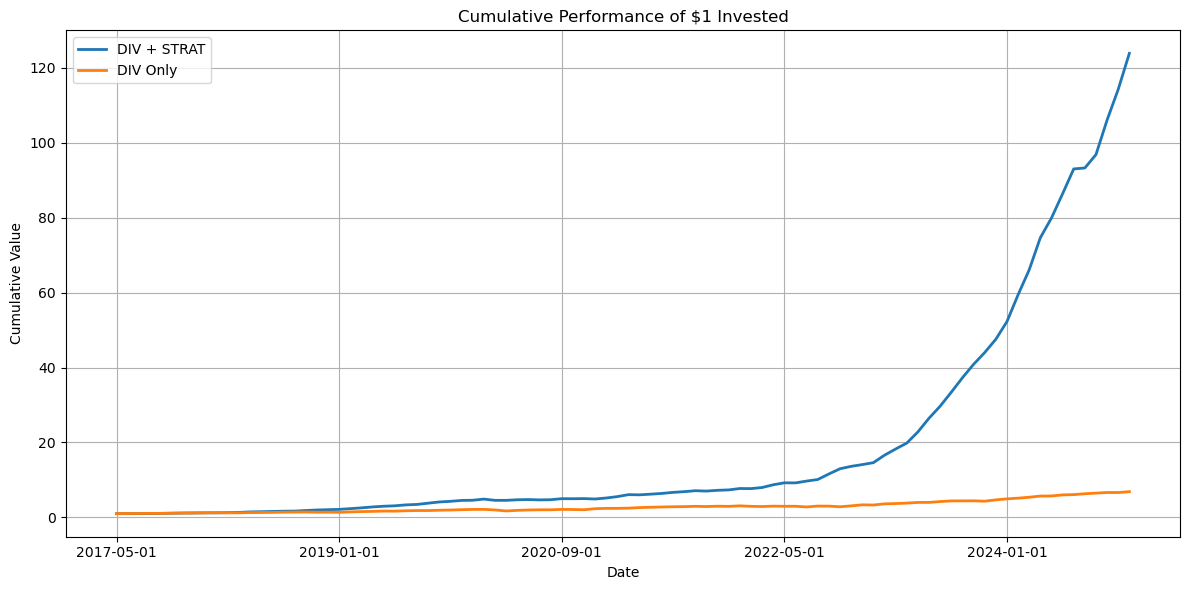

In [139]:
# Q8d
# Plot the cumulative performance of both DIV-only and DIV+STRAT fund strategies

df_strat, df_benchmark = ret_fund.align(df_div_final, join='inner')
# Add back the risk-free rate to the second FUND strategy 
df_final_strat = risk_free.loc[df_strat.index]["rf"] + df_strat
cum_strat = (1 + df_final_strat).cumprod()
cum_benchmark = (1 + df_benchmark).cumprod()
plt.figure(figsize=(12, 6))
cum_strat.plot(ax=plt.gca(), label='DIV + STRAT', linewidth=2)
cum_benchmark.plot(ax=plt.gca(), label='DIV Only', linewidth=2)

plt.title('Cumulative Performance of $1 Invested')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [140]:
# Calculate the mean, std and Sharpe ratio of the DIV only strategy
mean = 12*df_div_final["DIV Only"].mean()
std = np.sqrt(12)*df_div_final["DIV Only"].std()
sharpe = (mean-12*risk_free["rf"].mean())/(std)

print("DIV Only : ")
print(f"Mean return : {mean}")
print(f"Standard deviation : {std}")
print(f"Sharpe ratio : {sharpe}")

DIV Only : 
Mean return : 0.1141347626212183
Standard deviation : 0.1499518561459759
Sharpe ratio : 0.6612871341380504


In [141]:
# Calculate the mean, std and Sharpe ratio of the DIV+STRAT strategy
mean = 12*df_final_strat.mean()
std = np.sqrt(12)*df_final_strat.std()
sharpe = (mean-12*risk_free["rf"].mean())/(std)

print("DIV + STRAT : ")
print(f"Mean = {mean - 12*risk_free['rf'].mean()}")
print(f"Standard deviation : {std}")
print(f"Sharpe Ratio : {sharpe}")

DIV + STRAT : 
Mean = 0.6413045751708669
Standard deviation : 0.1532549448132033
Sharpe Ratio : 4.184560413058966


# 9 Performance and risk analysis for the Fund strategy

(a) Regress the time series of your new strategy returns on the Fama-French 5 research factors (that can be downloaded from Ken French’s webpage). Based on the magnitude of the beta estimates and their t-statistics, which factors seem to be significant drivers of the strategy returns unconditionally? Do these purely US-based risk factors explain the international equity and currency strategy performance well (look at the $R^2$, the $\beta$s, and the $\alpha$ from the regression)?


In [142]:
# Data Preprocessing for Fama-French 5 Factors

# from the csv file drop 3 first rows and 2 last ones and convert the data to a pandas dataframe
raw_data = pd.read_csv('data/fama-french-5factors/F-F_Research_Data_5_Factors_2x3.csv', skiprows=3, skipfooter=65, engine='python')

pd.read_csv('data/fama-french-5factors/F-F_Research_Data_5_Factors_2x3.csv', skiprows=3, skipfooter=65, engine='python')

# call column[0] 'Date' 
raw_data.rename(columns={raw_data.columns[0]: 'date'}, inplace=True)

# Convert 'Date' from 'YYYYMM' to 'YYYY-MM-DD' and set as index
raw_data['date'] = raw_data['date'].astype(str).str.zfill(6)  # Ensure all dates are 6 digits
raw_data['date'] = pd.to_datetime(raw_data['date'], format='%Y%m')
raw_data.set_index('date', inplace=True)


# drop date before 2002-05-01 and after 2024-12-01
raw_data = raw_data[(raw_data.index >= '2017-06-01') & (raw_data.index <= '2024-12-01')].div(100.0)

raw_data.to_csv('data/preprocess/fama-french.csv')

print(raw_data.head())

            Mkt-RF     SMB     HML     RMW     CMA      RF
date                                                      
2017-06-01  0.0078  0.0252  0.0150 -0.0226  0.0004  0.0006
2017-07-01  0.0188 -0.0164 -0.0023 -0.0075 -0.0015  0.0007
2017-08-01  0.0018 -0.0183 -0.0213  0.0020 -0.0238  0.0009
2017-09-01  0.0249  0.0476  0.0315 -0.0154  0.0163  0.0009
2017-10-01  0.0225 -0.0191  0.0013  0.0092 -0.0314  0.0009


In [143]:
# Q9a
# Regress the time series of your new strategy returns returns.csv on the the Fama-French 5 research factors preprocess/fama-french.csv.

fama_french = pd.read_csv('data/preprocess/fama-french.csv', index_col='date', parse_dates=True)

X_m = sm.add_constant(fama_french[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])
y_m = df_strat.iloc[1:].copy() # excess return of R_FUND from June
y_m.index = pd.to_datetime(y_m.index)
strat_on_fama_french = sm.OLS(y_m, X_m).fit()

print(">>> Regression of STRAT on Fama-French:")
print(strat_on_fama_french.summary())
print("\n")

>>> Regression of STRAT on Fama-French:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     2.781
Date:                Sun, 15 Jun 2025   Prob (F-statistic):             0.0224
Time:                        15:31:30   Log-Likelihood:                 164.23
No. Observations:                  91   AIC:                            -316.5
Df Residuals:                      85   BIC:                            -301.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

(b) How can we explain the performance of the strategy that you just built? Is it consistent with efficient markets, with the CAPM, and with the APT?


In [144]:
# Regress the time series of your new strategy returns returns.csv on the the CAPM

fama_french = pd.read_csv('data/preprocess/fama-french.csv', index_col='date', parse_dates=True)

X_m = sm.add_constant(fama_french['Mkt-RF'])
y_m = df_strat.iloc[1:].copy() # excess return of R_FUND from June
y_m.index = pd.to_datetime(y_m.index)
strat_on_fama_french = sm.OLS(y_m, X_m).fit()

print(">>> Regression of STRAT on CAPM:")
print(strat_on_fama_french.summary())
print("\n")

>>> Regression of STRAT on CAPM:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.3639
Date:                Sun, 15 Jun 2025   Prob (F-statistic):              0.548
Time:                        15:31:30   Log-Likelihood:                 157.53
No. Observations:                  91   AIC:                            -311.1
Df Residuals:                      89   BIC:                            -306.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.05

To better understand the nature of the strategy’s performance, we evaluate whether it aligns with the predictions of three major asset pricing paradigms: the Capital Asset Pricing Model (CAPM), the Arbitrage Pricing Theory (APT), and the Efficient Markets Hypothesis (EMH).

The CAPM posits that expected excess returns are fully explained by exposure to the market factor, such that the regression intercept ($\alpha$) should be zero. In our CAPM regression, however, we find a highly significant and positive alpha ($\alpha = 0.054$, $t = 11.6$, $p < 0.001$) and a statistically insignificant market beta ($\beta_{\text{Mkt}} = -0.056$, $p = 0.55$). This result contradicts the CAPM’s central implication and indicates that the strategy's returns are not explained by systematic market risk alone.

The APT generalizes the CAPM by allowing for multiple priced sources of systematic risk. In equilibrium, if all relevant risk factors are included, most assets should exhibit no abnormal return (i.e., $\alpha \approx 0$). The significant alpha we observe suggests that important risk factors are missing from the regression. These could include exposures to global equity risk, FX carry, international momentum, liquidity shocks, or tail-risk compensation. While our results are inconsistent with a fully specified APT model, they do not contradict the theory itself; rather, they point to an incomplete factor specification.

According to the Efficient Markets Hypothesis (EMH), once all known sources of risk are properly accounted for, no strategy should consistently earn statistically significant abnormal returns. The persistent and significant alpha observed here could thus reflect either (i) compensation for omitted but legitimate sources of risk, in line with EMH, or (ii) the presence of true market inefficiencies that persist due to frictions such as transaction costs, funding constraints, or behavioral biases. The EMH does not rule out abnormal returns, but predicts that they should disappear when all relevant risks are correctly modeled.

Overall, the strategy’s performance appears inconsistent with the CAPM, potentially consistent with the APT if global and currency risk factors were included, and inconclusive with respect to EMH. The combination of a negative market beta and a large positive alpha also suggests attractive diversification properties, reinforcing the international and multi-asset insights discussed in Lectures 2–4.
